# Import Packages & Data

In [3]:
import numpy as np               # NumPy
import pandas as pd              # Pandas
import re                        # Re?
from datetime import datetime    # Calculates Processing Time
import random

# SciKit Learn
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

# kappa metric for measuring agreement of automatic to human scores
from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

# MatPlots
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100
plt.style.use('ggplot')

Processing time: 0:00:00.204239


In [13]:
# Import Pre-processed Data
training_set = pd.read_pickle('preprocessedTrainingNoEssay.pkl')
training_set.sample(3)

# Select features
predictors = [  
    "word_count",
    "TTR",
    "readability",
    "unique_token_count",
    "ner",
    "sw_ratio",
    "ners_ratio"]

,essay_id,topic,target_score,ner,word_count,token_count,unique_token_count,nostop_count,sent_count,ner_unredacted_count,dw_ratio,h_similarity,sw_ratio,ners_ratio,TTR,flesch,smog,kincaid,coleman_liau,readability,dale_chall,difficult_words,linsear,gunning_fog,grade_level,comma,question,exclamation,quotation,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
10563,16513,6,3,6,918,173,101,87,12,6,0.033769,0.984248,76.500000,0.500000,0.583815,62.88,11.2,8.7,11.13,10.9,7.71,31,20.000,9.90,10th and 11th grade,7,0,0,3,45,6,1,28,3,5,29,8,4,6,0
8692,13440,5,2,2,571,111,77,43,9,2,0.021016,0.977070,63.444444,0.222222,0.693694,63.22,11.7,10.6,10.04,13.4,6.78,12,14.625,11.13,10th and 11th grade,2,0,0,4,20,7,7,20,3,11,17,2,0,2,0
8327,13075,5,3,15,678,147,84,64,14,2,0.025074,0.977841,48.428571,1.071429,0.571429,55.61,11.2,13.5,6.51,14.8,7.32,17,14.500,15.09,14th and 15th grade,1,0,0,8,20,7,11,27,2,8,21,14,0,4,0


# Regression Pipeline

In [ ]:
def evaluate(df, topic, features, model):
    """Regression pipeline with kappa evaluation"""

    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    # token_ct = X.token_count
    # X = X.div(token_ct, axis=0)
    # X['token_count'] = X['token_count'].mul(token_ct, axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    pipeline = Pipeline(model)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [8]:
# for use in pipeline
models = [
            [('scaler', StandardScaler()),('linearSVC', LinearSVC(C=0.01))] ,
            [('scaler', StandardScaler()),('lm', LinearRegression())], 
            [('rf', RandomForestRegressor(random_state=26))],  
            [('en', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000, random_state=26))] 
        ]

for steps in models:
    kappas = []
    weights = []
    for topic in range(1,9):
        kappas.append(evaluate(training_set, topic, predictors, steps))
        weights.append(len(training_set[training_set.topic==topic]))

    mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
    print(steps)
    print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
    print('')

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearSVC', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
Weighted by topic Kappa score: 0.5876

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))]
Weighted by topic Kappa score: 0.6954



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=26, verbose=0,
                      warm_start=False))]
Weighted by topic Kappa score: 0.6831

[('en', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=26, selection='cyclic', tol=0.0001, warm_start=False))]
Weighted by topic Kappa score: 0.6878



In [ ]:
# ElasticNet with GridSearchCV for each individual topic

def en_evaluate(df, topic, features):
    # Regression pipeline with kappa evaluation
    paramgrid = {'l1_ratio': [.01, .1, .3, .5, .7, .99], 'alpha': [0.001, 0.01, 0.1, 1]}
    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),
                      param_grid=paramgrid,
                      cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [10]:
kappas = []
weights = []
for topic in range(1,9):
    kappas.append(en_evaluate(training_set, topic, predictors))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 2 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 3 best parameters: {'alpha': 0.1, 'l1_ratio': 0.99}
Topic 4 best parameters: {'alpha': 0.001, 'l1_ratio': 0.7}
Topic 5 best parameters: {'alpha': 0.001, 'l1_ratio': 0.01}
Topic 6 best parameters: {'alpha': 0.001, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 8 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Weighted by topic Kappa score: 0.6947


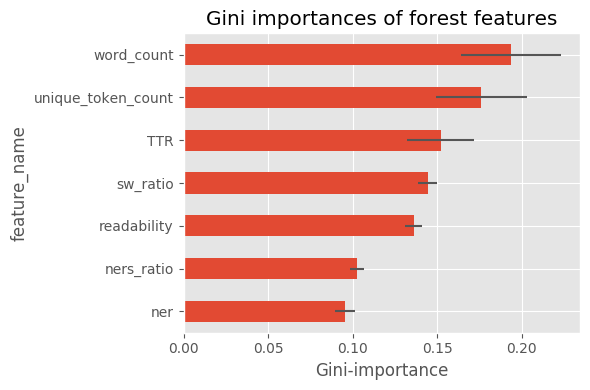

In [11]:
X = training_set[predictors]
y = training_set['target_score'].astype(np.float64)


forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=26)

forest.fit(X, y)

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# plot feature importances

features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance')\
        .plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.tight_layout()
plt.show()

In [12]:
# best k features
k = 15
top_features = features.sort_values('importance', ascending=False)['feature_name'].tolist()[:k]

# Linear regression with top k features
kappas = []
weights = []
steps = [('scaler', StandardScaler()),('lm', LinearRegression())]
for topic in range(1,9):
    kappas.append(evaluate(training_set, topic, top_features, steps))
    weights.append(len(training_set[training_set.topic==topic]))

mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Weighted by topic Kappa score: 0.6954
